# Tutorial 18: IVPs and Random Numbers

## PHYS 2600

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## T16.1 - Numerical instability

Let's start by solving for the velocity of an object in freefall. To keep things simple, we're going to assume that the velocity only has a vertical component $u(t)$ and we'll choose a coordinate system where $u(t)>0$ when the object is moving towards the ground. There are two forces we need to account for

<div style="display:flex; align-items:center; gap:16px;">
  <a href="https://commons.wikimedia.org/wiki/File:Terminal_Velocity.png" target="_blank">
    <img src="https://raw.githubusercontent.com/wlough/CU-Phys2600-Fall2025/main/lectures/img/Terminal_Velocity.png" width="100">
  </a>

  <div style="margin-left:2rem;"> 
  $$
  F_{\text{d}} = -\gamma u
  $$
  $$
  F_{\text{g}} = mg
  $$
  </div>
</div>

where $m$ is the object's mass and $\gamma$ is a drag coefficient.
Since acceleration is the derivative of velocity, Newton's second law tells us 
$$
m u'(t) = mg -\gamma u(t).
$$
If we write $u_{\infty} = \frac{mg}{\gamma}$ for the terminal velocity and define a time constant $\tau = \frac{m}{\gamma}$, this is equivalent to to the equation
$$
u'(t) = -\frac{1}{\tau} \left(u(t)-u_{\infty}\right)
$$
which has the analytic solution
$$
u(t) = u_0e^{-t/\tau} + u_{\infty}\left(1-e^{-t/\tau}\right)
$$

__Run the cell below__ to plot the analytic solution over the range $0 \leq t \leq 1$.

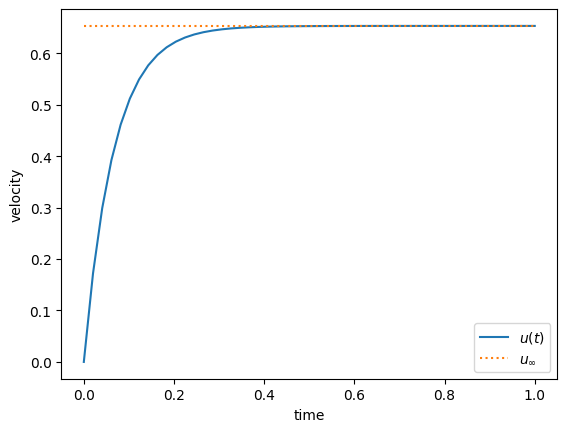

In [2]:
g, m, gamma = 9.8, 0.1, 1.5
u_inf = m * g / gamma
tau = m / gamma
u0 = 0.0

def get_exact_fun(u0, t0=0.0):
    return lambda t: u0 * np.exp(-(t-t0) / tau) + u_inf * (1 - np.exp(-(t-t0) / tau))

u_exact_fun = get_exact_fun(u0)
t_exact = np.linspace(0, 1.0, 50)
u_exact = u_exact_fun(t_exact)

plt.plot(t_exact, u_exact, label="$u(t)$")
plt.plot([t_exact[0], t_exact[-1]], [u_inf, u_inf], label=r"$u_{\infty}$", linestyle=":")
plt.xlabel("time")
plt.ylabel("velocity")
plt.legend()
plt.show()

We're going to find an approximate solution to the freefall equation using the backward Euler method. To set up a backward Euler solver for an IVP

$$
u'(t) = F(u(t), t), \quad u(0)= c
$$

we do the following:

__(1)__ Choose a discrete set of $t$-values.
$$t_k = t_0 + k\Delta t \quad \text{for} \quad k=0,1,\dots, N-1$$
__(2)__ Replace the derivative on the with a backward difference evaluated at $t=t_{i+1}$.
$$u'(t_{i+1})\approx (u_{i+1} - u_{i})/\Delta t$$
__(3)__ Evaluate the right hand side at $t=t_{i+1}$.
$$
\left.F(u(t), t)\right|_{t=t_{i+1}}=F(u_{i+1}, t_{i+1})
$$
__(4)__ Do a little bit of algebra to get our implicit equation
$$
 u_{i+1} - u_i - \Delta t F(u_{i+1}, t_{i+1}) = 0
$$
__(5)__ Start with the initial condition $u_0=c$ and solve the implicit equation at each timestep to compute subsequent values of $u$.
$$
\begin{align}
u_0 &= c\\
\text{solve}\quad u_{1} - u_{0} - &\Delta t F(u_{1}, t_{1}) = 0\quad \text{for}\quad u_{1}\\
\text{solve}\quad u_{2} - u_{1} - &\Delta t F(u_{2}, t_{2}) = 0\quad \text{for}\quad u_{2}\\
&\vdots \\
\text{solve}\quad u_{i+1} - u_{i} - &\Delta t F(u_{i+1}, t_{i+1}) = 0\quad \text{for}\quad u_{i+1}\\
\end{align}
$$

Generally you need to use a root finding algorithm like Newton's method to solve for $u_{i+1}$ at each timestep. In some problems (like the freefall problem!), $F$ is simple enough that we can actually solve the implicit equation to find an explicit formula for $u_{i+1}$.

### Part A: Solving the implicit equation by hand
In the text cell below, write the __implicit__ equation that needs to be solved at each timestep to find $u_{i+1}$ for the freefall equation.

YOUR SOLUTION HERE

<!--BEGIN SOLUTION  -->
Using $F(u_{i+1}, t_{i+1}) = -\left(u_{i+1}-u_{\infty}\right)/\tau$, we have

$$
u_{i+1} - u_{i} + \Delta t \left(u_{i+1}-u_{\infty}\right)/\tau = 0
$$

<!--END SOLUTION  -->

We'll come back to the implicit equation in part B, but we're going to start by solving the implicit equation by hand. Solve the implicit equation to get an __explicit__ formula for $u_{i+1}$ and write your answer in the text cell below.

YOUR SOLUTION HERE

<!--BEGIN SOLUTION  -->
Solving our implicit equation for $u_{i+1}$ gives

$$
u_{i+1} = \frac{u_i+\Delta t u_{\infty}/\tau}{1+\Delta t/\tau}
$$

<!--END SOLUTION  -->

Implement the function `backward_euler_step_explicit(ui, dt)` which should use your __explicit__ formula to calculate and return $u_{i+1}$ given $u_i$ and a step size $\Delta t$.

In [3]:
def backward_euler_step_explicit(ui, dt):
    ### BEGIN SOLUTION
    return (ui+dt*u_inf/tau)/(1+dt/tau)
    ### END SOLUTION


In [4]:
import numpy.testing as npt

npt.assert_allclose(backward_euler_step_explicit(0, 0.1), 0.392)
npt.assert_allclose(backward_euler_step_explicit(0, 0.01), 0.085217, atol=1e-4)
npt.assert_allclose(backward_euler_step_explicit(0.08521739, 0.01), 0.159319, atol=1e-4)

Now implement a function `backward_euler_solve_explicit(t, u0)` which uses your `backward_euler_step_explicit` to compute the numerical solution from an array of time samples `t=[t_0, t_1,...]` and an initial velocity `u0`.

In [5]:

def backward_euler_solve_explicit(t, u0):
    ### BEGIN SOLUTION
    u = np.zeros_like(t)
    u[0] = u0
    dt = t[1] - t[0]
    for i in range(0, len(t) - 1):
        u[i + 1] = backward_euler_step_explicit(u[i], dt)
    return u
    ### END SOLUTION

Let's compare our numerical solution to the analytic solution. Use your `backward_euler_solve_explicit` function to solve the freefall IVP over the time interval $0 \leq t \leq 1$ with initial condition $u(0)=0$ and add it to the plot below.

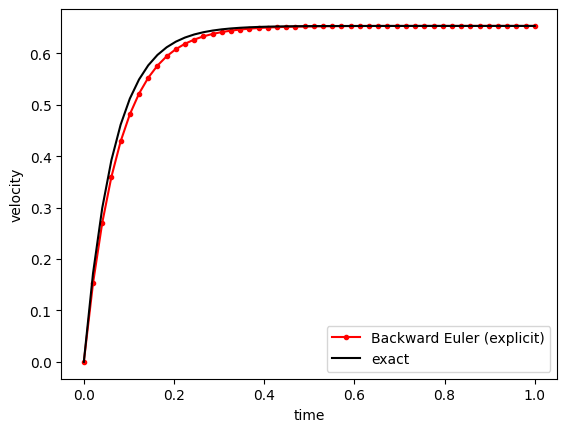

In [6]:
### BEGIN SOLUTION
t = np.linspace(0, 1.0, 50)
u_explicit = backward_euler_solve_explicit(t, 0.0)
plt.plot(t, u_explicit, color="r", marker=".", label="Backward Euler (explicit)")
### END SOLUTION

plt.plot(t_exact, u_exact, color="k", label="exact")
plt.xlabel("time")
plt.ylabel("velocity")

plt.legend()

### Part B: Solving the implicit equation numerically

For most IVPs the implicit equation that you get from Backward Euler doesn't have an analytic solution and needs to be solved numerically.

Implement the function `backward_euler_step(ui, dt)` which uses `newton` to solve your __implicit__ equation for $u_{i+1}$ given $u_i$ and a step size $\Delta t$. (Hint: you can use the result of a forward Euler step $u^{\text{guess}}_{i+1} = u_{i}+\Delta t F(u_i)$ as your guess to initialize Newton's method.)

In [7]:
from scipy.optimize import newton

def backward_euler_step(ui, dt):
    ### BEGIN SOLUTION
    def implicit_eq(uip1):
        return uip1 - ui + dt*(uip1 - u_inf)/tau

    uip1_guess = ui - dt*(ui - u_inf)/tau
    return newton(implicit_eq, uip1_guess)
    ### END SOLUTION


In [8]:
# testing cell
npt.assert_allclose(backward_euler_step(0, 0.1), 0.392)
npt.assert_allclose(backward_euler_step(0, 0.01), 0.085217, atol=1e-4)
npt.assert_allclose(backward_euler_step(0.08521739, 0.01), 0.159319, atol=1e-4)

Now implement a function `backward_euler_solve(t, u0)` which uses your `backward_euler_step` to compute the numerical solution from an array of time samples `t=[t_0, t_1,...]` and an initial velocity `u0`. Then run the next cell to see how it compares with the analytic and Forward Euler solution for a range of step sizes.

In [9]:
def backward_euler_solve(t, u0):
    ### BEGIN SOLUTION
    u = np.zeros_like(t)
    u[0] = u0
    dt = t[1] - t[0]
    for i in range(0, len(t) - 1):
        u[i + 1] = backward_euler_step(u[i], dt)
    return u
    ### END SOLUTION

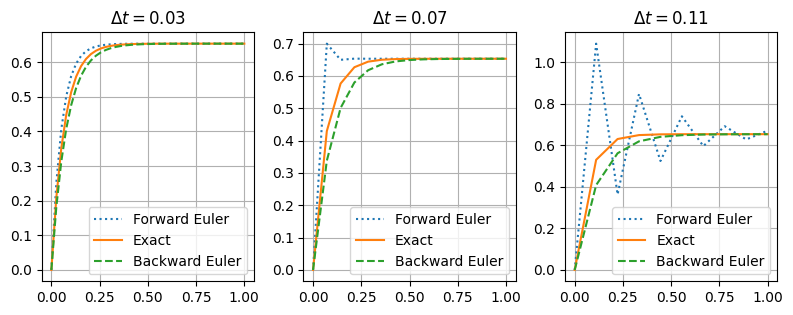

In [22]:
def forward_euler_solve(t, u0):
    u = np.zeros_like(t)
    u[0] = u0
    dt = t[1] - t[0]
    for i in range(0, len(t) - 1):
        u[i + 1] = u[i] - dt*(u[i] - u_inf)/tau
    return u

def fb_compare_plot(u0, t_final, Nt_list):

    u_exact_fun = get_exact_fun(u0)

    num_rows = len(Nt_list)
    fig, axes = plt.subplots(1, num_rows, figsize=(8, 3.25))

    for ax, Nt in zip(axes, Nt_list):
        t = np.linspace(0, t_final, Nt)
        u_exact = u_exact_fun(t)
        u_fe = forward_euler_solve(t, u0)
        u_be = backward_euler_solve(t, u0)

        dt = t[1] - t[0]
        ax.set_title(r"$\Delta t =" + f"{dt: 0.2f}" + r"$")
        ax.plot(t, u_fe, linestyle=":", label="Forward Euler")
        ax.plot(t, u_exact, linestyle="-", label="Exact")
        ax.plot(t, u_be, linestyle="--", label="Backward Euler")
        ax.grid(True)
        ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

Nt_list = [40, 15, 10]
fb_compare_plot(0, 1, Nt_list)

## T18.2 - Warming up with random numbers

### Part A

Using `np.random.randint()` _without setting the seed_, generate 10 random integers from the set `(0,1,2,3)`.  Then, set the seed to 1414, and generate another 10 random integers.

In [11]:
print(np.random.randint(0,5,size=10))
np.random.seed(1414)
print(np.random.randint(0,5,size=10))

[1 4 1 3 3 4 0 3 0 2]
[4 2 4 0 0 4 0 1 1 2]


Now compare your results with your neighbor:

- Did you get completely different results without the seed?
- What if you try to run the cell at the same time?  (Does this prove anything to you about how the computer's clock is used in choosing seeds?)
- Do your results match with the _same_ seed?
- Once you've used the seed, comment the seed line out - _now_ how do your results compare to your neighbors?  (If you want to go back to a randomly determined seed, restart the kernel or call `np.random.seed()` with no argument.)

### Part B

The workhorse function of the `numpy.random` module is `np.random.rand()`, which generates real numbers which are uniformly distributed between $0$ and $1$.  

Let's test just _how_ uniform the distribution is!  Use `np.random.rand()` to generate __10,000 random numbers__ in $(0,1)$.  Then use `plt.hist()` to __make a histogram plot__ of the results, using __20 bins__ (read the documentation by searching for it or using `plt.hist?`.)  

(array([5142., 4999., 4940., 5028., 4965., 5000., 4893., 4987., 5010.,
       5079., 5082., 4992., 5025., 4890., 5106., 4950., 4976., 4884.,
       5006., 5046.]), array([3.08839842e-06, 5.00027005e-02, 1.00002313e-01, 1.50001925e-01,
       2.00001537e-01, 2.50001149e-01, 3.00000761e-01, 3.50000373e-01,
       3.99999985e-01, 4.49999597e-01, 4.99999209e-01, 5.49998821e-01,
       5.99998433e-01, 6.49998046e-01, 6.99997658e-01, 7.49997270e-01,
       7.99996882e-01, 8.49996494e-01, 8.99996106e-01, 9.49995718e-01,
       9.99995330e-01]), <BarContainer object of 20 artists>)


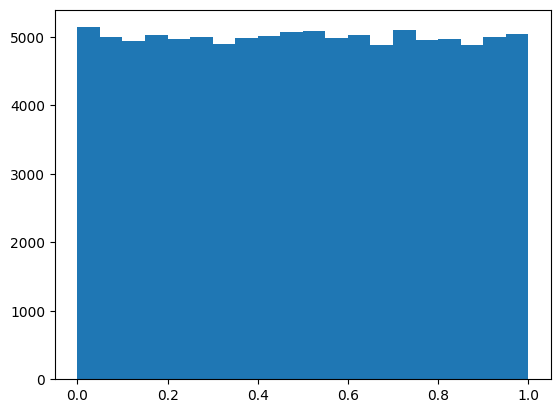

In [12]:
R = np.random.rand(int(1e5))  # Returns (shape) numbers in the range[0,1).
H = plt.hist(R,bins=20)
print(H)  # H contains: counts, bin edges, and the histogram plot itself

Does it seem uniform to you?  __Re-run the cell__ a few times to see how the distribution fluctuates.  Feel free to adjust the number of random draws - you should see the distribution get smoother as you include more and more points.

### Part C

__Generate 50 random angles__ $\theta$ between 0 and $2\pi$, using `np.random.rand()`.  (Remember, the number generated by this function are _always_ in the range $(0,1)$ - make adjustments to the interval by adding or multiplying by the appropriate constants.)

Then, __plot the resulting polar-coordinate points $(\cos \theta, \sin \theta)$__ (with polar radius $r=1$) using `plt.scatter`.  The points should all trace the outline of a circle.  (I've given you an initial command to set the aspect ratio to be square - by default, `matplotlib` plots are rectangular, which will make your circle look like an ellipse.)

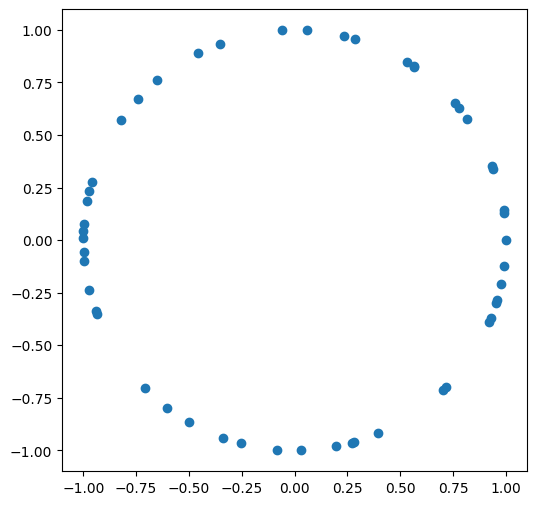

In [13]:
plt.figure(figsize=(6,6))  # Square aspect ratio, so the circle doesn't look squashed

### BEGIN SOLUTION
theta = np.random.rand(50) * 2 * np.pi
plt.scatter(np.cos(theta), np.sin(theta))
### END SOLUTION

## T18.3 - The random walk

In physics, _statistical mechanics_ starts from the kinematics of individual molecules and allows us to make predictions about the aggregate behavior of something like a gas.  

Similarly, we can use a computer to simulate the motion of individual gas particles and try to study the properties of gases in aggregate.  However, solving using Newton's laws is not that easy here, especially since we would have to deal with collisions and with other forces between molecules to get a realistic model.  

Instead, a quick and dirty model of a gas can be obtained using a __random walk__, in which each particle moves around independently and randomly.  As long as the number of molecules is large enough, the random walk can capture all of the microscopic physics of molecules kicking each other around. 

([Here's a simulation of simple motion and collisions](https://www.youtube.com/watch?v=1jYabtziQZo) - you can see that the behavior of the highlighted particle resembles random motion, even with a pretty small number of particles.)

### Part A

__Implement the function `step_random_walk_2d(x_coords, y_coords)` below__, which should take two arrays of equal length containing the x- and y-coordinates for some number of particles.  We'll use a very simple random walk algorithm:

- For each particle, choose a random angle $\phi$ between 0 and $2\pi$.
- The particle moves by 1 unit of distance in the direction given by $\phi$, i.e. it is displaced by $(\Delta x, \Delta y) = (\cos \phi, \sin \phi)$.

(This is exactly what you already did in T18.2C above, in fact!)

We'll do this in a _vectorized_ approach: we draw all the angles at once in a single array, and then calculate and apply the displacements using NumPy functions.  Your function should _update the coordinates in-place_, which means it shouldn't return anything!  I've sketched out the algorithm with some comments for you below.

In [14]:
def step_random_walk_2d(x_coords, y_coords):
    # Vectorized algorithm:
    
    # Draw an array of random angles phi, uniformly between 0 and 2*pi
    # You should draw one angle for every particle.
    
    # Use numpy functions (no for loops!) to calculate the arrays
    # delta_x and delta_y, the displacements for each particle
    
    # Update x_coords and y_coords in place, i.e. overwrite
    # those variables with the displaced arrays
    
    ### BEGIN SOLUTION
    phi = np.random.rand(len(x_coords)) * 2 * np.pi
    x_coords += np.cos(phi)
    y_coords += np.sin(phi)
    ### END SOLUTION    
    
    # Return None (since we changed the arrays in-place)
    return None
    


Now in the cell below, __create an initial distribution of 100 particles at the origin $(0,0)$__, apply _one step_ of your function `step_random_walk_2d(x,y)` above, and then call `plt.scatter` to __plot the positions after one step.__  You should see them distributed around a circle, due to the algorithm that we chose.  

(This doesn't look very random, of course!  But you'll see that despite this structure on step 1, the behavior after many steps will look much less uniform.)

100


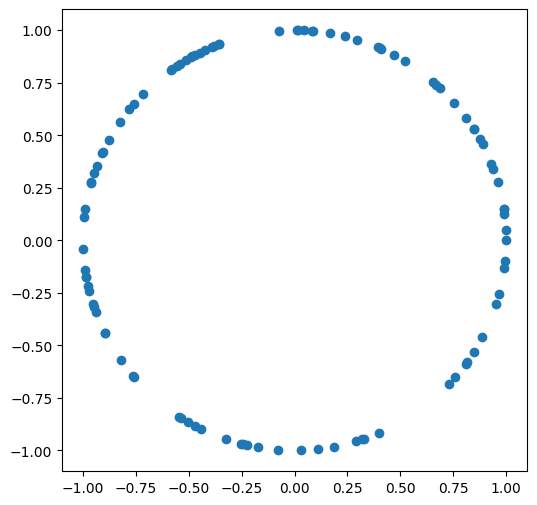

In [15]:
x, y = np.zeros(100), np.zeros(100)
print(x.size)
step_random_walk_2d(x, y)

plt.figure(figsize=(6,6))
plt.scatter(x,y)

Now __use a for loop to take 50 steps__, and plot the distribution of particles again.  Now it should look pretty randomized!  Notice how the vertical and horizontal scale of the plot has changed, too.

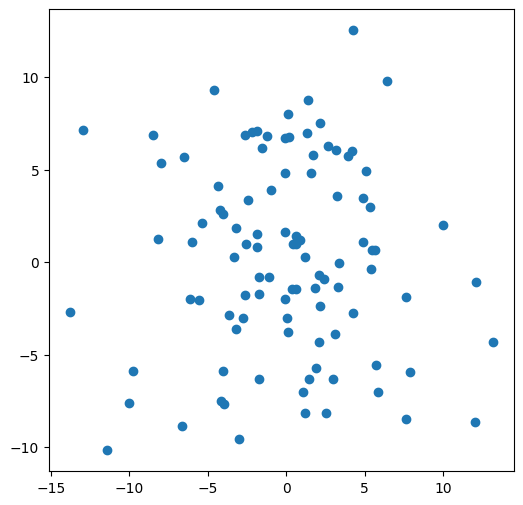

In [16]:
x, y = np.zeros(100), np.zeros(100)
for dummy in range(50):
    step_random_walk_2d(x, y)

plt.figure(figsize=(6,6))
plt.scatter(x,y)

Finally, __run the definition of `plot_random_walk_2d` and the cell afterwards__ to animate your random walk!  (This also gives you a demonstration of how to create animated plots in Jupyter - the details are a little complicated, which is why I'm just demoing this for you.)

In [17]:
import matplotlib.animation as animation
from IPython.display import HTML

def plot_random_walk_2d(Np, Ns, steps_per_plot=5):
    """
    Simulate a random walk in two dimensions.
    
    Arguments:
    =====
    * Np: number of particles to simulate.
    * Ns: number of steps to simulate.
    * steps_per_plot: how many steps to wait in between 
        plotting the positions of the particles (default: 10.)

    Returns:
    =====
    * fig, frames: plots of the particle positions, 
        formatted as needed to create an animated graph.

    """
    
    # Setup for animated plots
    fig, ax = plt.subplots(figsize=(8,8))
    frames = []
    
    # Initialize two arrays, x_coords and y_coords, of length Np
    x_coords = np.zeros(Np)
    y_coords = np.zeros(Np)
    
    for step in range(Ns):
        # If step is divisible by steps_per_plot, make a plot
        if step % steps_per_plot == 0:
            frame = ax.plot(x_coords, y_coords, linestyle=' ', marker='.', color='blue')
            frames.append(frame)        
        
        # Take a random step
        step_random_walk_2d(x_coords, y_coords)

    return fig, frames


In [18]:
fig, frames = plot_random_walk_2d(Np=100, Ns=400)
ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True, repeat=False)
plt.close(fig)  ## Stops Jupyter from showing the last frame alongside the animated plot

HTML(ani.to_html5_video()) 

This is an incredibly simple simulation, but it already exhibits the phenomenon of __diffusion__: the particles, which started tightly packed into a region of high density, are spreading out and becoming less dense over time.  In fact, we could do some statistical tests on the distribution vs. time to quantify this behavior in terms of a _diffusion coefficient_.  (But we'll need to learn about models and fitting to data before we can do that.)

### Part B (optional challenge)

If we really wanted to try something like studying the ideal gas law, it would be better to have our particles trapped in a finite volume.  A simple but physically-motivated modification to our algorithm we could make for a finite volume would be: if any particle would be displaced _outside_ the volume, it moves in the _opposite direction_ instead.

Can you rewrite `step_random_walk_2d` so that __all of the gas particles are trapped in the square region__ $-10 \leq x,y \leq 10$, using this simple algorithm?  Then try to re-run the definition of `plot_random_walk_2d` above and see how your plot looks now.

_(Hint: you want to create a mask array which is `True` for any particle that's outside the volume.  This is a combination of four masks which check the four boundaries of the square.  Use_ `np.logical_or()` _to combine multiple masks into one that's `True` if any of them is `True`.)_

In [19]:
def step_random_walk_2d(x_coords, y_coords):
    ### BEGIN SOLUTION
    phi = np.random.rand(len(x_coords)) * 2 * np.pi
    
    dx = np.cos(phi)
    dy = np.sin(phi)
    
    # Shift particles
    x_coords += dx
    y_coords += dy
    
    # Create a mask for anywhere the update would be outside the boundary
    x_mask = np.logical_or(x_coords < -10, x_coords > 10)
    y_mask = np.logical_or(y_coords < -10, y_coords > 10)
    
    oob_mask = np.logical_or(x_mask, y_mask)
    
    # Updates become negative where the mask applies
    x_coords[oob_mask] -= 2*dx[oob_mask]
    y_coords[oob_mask] -= 2*dy[oob_mask]
    ### END SOLUTION  
    
    return None


For fun, here's code to animate your modified function, so you can see if your particles are truly staying confined.

In [20]:
import matplotlib.animation as animation
from IPython.display import HTML

def plot_random_walk_2d(Np, Ns, steps_per_plot=5):
    """
    Simulate a confined random walk in two dimensions.
    
    Arguments:
    =====
    * Np: number of particles to simulate.
    * Ns: number of steps to simulate.
    * steps_per_plot: how many steps to wait in between 
        plotting the positions of the particles (default: 10.)

    Returns:
    =====
    * fig, frames: plots of the particle positions, 
        formatted as needed to create an animated graph.

    """
    
    # Setup for animated plots, include lines to show confining box
    fig, ax = plt.subplots(figsize=(8,8))
    plt.xlim(-12,12)
    plt.ylim(-12,12)
    ax.hlines(y=10, xmin=-10, xmax = 10, color='r', linestyle='-')
    ax.hlines(y=-10, xmin=-10, xmax = 10, color='r', linestyle='-')
    ax.vlines(x=10, ymin=-10, ymax = 10, color='r', linestyle='-')
    ax.vlines(x=-10, ymin=-10, ymax = 10, color='r', linestyle='-')
    
    frames = []
    
    # Initialize two arrays, x_coords and y_coords, of length Np
    x_coords = np.zeros(Np)
    y_coords = np.zeros(Np)
    
    for step in range(Ns):
        # If step is divisible by steps_per_plot, make a plot
        if step % steps_per_plot == 0:
            frame = ax.plot(x_coords, y_coords, linestyle=' ', marker='.', color='blue')
            frames.append(frame)        
        
        # Take a random step
        step_random_walk_2d(x_coords, y_coords)

    return fig, frames


In [23]:
fig, frames = plot_random_walk_2d(Np=100, Ns=400)
ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True, repeat=False)
plt.close(fig)  ## Stops Jupyter from showing the last frame alongside the animated plot

HTML(ani.to_html5_video())